In [20]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [21]:
from utils import *
from data import *
from models import *
from train import *

In [22]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [24]:
data_mit = import_mit_data()

In [25]:
beats = []
freq = 360

for i,patient in tqdm(enumerate(data_mit), total=len(data_mit)):
    for waveform, label in patient:
        rpeaks = wfdb.processing.xqrs_detect(waveform, fs=freq, verbose=False)

        for peak in rpeaks:
            if peak >= freq/2 and peak < len(waveform) - freq/2:
                partial_wave = waveform[peak-freq//2:peak+freq//2]
                partial_wave,_ = pywt.dwt(partial_wave, 'db6')
                partial_wave,_ = pywt.dwt(partial_wave, 'db6')
                beats.append((partial_wave, label, i)) 

100%|██████████| 48/48 [00:59<00:00,  1.24s/it]


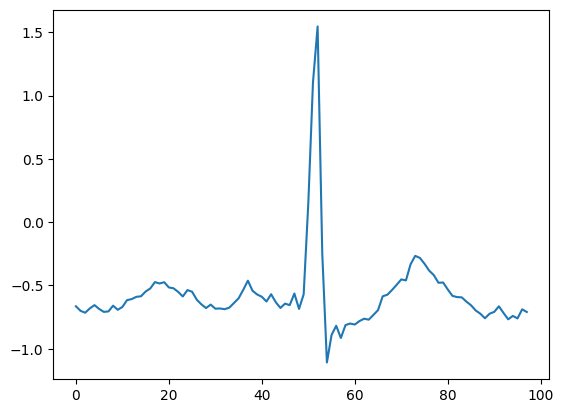

In [26]:
def plotbeat(x):
    if type(x) is tuple:
        plt.plot(x[0])
    else:
        plt.plot(x)

plotbeat(beats[0])

# Dataset

In [27]:
labels = list(set([x[1] for x in beats]))
label_map = {label:i for i,label in enumerate(labels)}

In [32]:
class BeatDataset(Dataset):
    def __init__(self, data, device, label_map, specify_patient=None):
        self.data = []

        for waveform, label, patient in tqdm(data):
            if specify_patient:
                if patient != specify_patient:
                    continue
                

            ## Z-score Normalisation
            waveform = (waveform - waveform.mean()) / waveform.std()

            self.data.append((
                torch.tensor(waveform, device=device, dtype=torch.float32),
                torch.tensor(label_map[label], device=device),
                patient
            ))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        waveform, label, patient = self.data[idx]

        return waveform, label
    
beat_dataset = BeatDataset(beats, device, label_map)
beat_dataloader = DataLoader(beat_dataset, batch_size=512, shuffle=True)

100%|██████████| 76851/76851 [00:02<00:00, 27962.75it/s]


In [34]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=1, hidden_size=embedding_dim, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)

    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1))
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        _, hidden = self.lstm2(x)

        # return lstm_out[:,-1,:]
        return hidden
    
class Decoder(nn.Module):
    def __init__(self, seq_len=98, embedding_dim=32):
        super().__init__()

        self.seq_len = seq_len
        
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        self.output_layer = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        # x = x.unsqueeze(1).repeat(1,self.seq_len,1)
        x,_ = self.lstm1(torch.zeros([x[0].shape[1], self.seq_len, x[0].shape[2]], device=x[0].device), x)
        x = self.dropout1(x)
        x,_ = self.lstm2(x)
        x = self.dropout2(x)
        x = self.output_layer(x)

        return x.squeeze(2)

class AEModel(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()

        self.encoder = Encoder(embedding_dim=embedding_dim)
        self.decoder = Decoder(embedding_dim=embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AEModel(embedding_dim=16).to(device)
# model.load_state_dict(torch.load('autoencoder.pt'))

In [35]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

losses = []

In [126]:
for epoch in range(1000):
    model.train()

    for i,batch in enumerate(beat_dataloader, 0):

        optimizer.zero_grad()

        seq, label = batch

        seq_pred = model.forward(seq)

        loss = criterion(seq, seq_pred)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.)
        optimizer.step()

    if epoch % 10 == 0:
        model.eval()

        totalloss = 0.

        with torch.no_grad():
            for i,batch in enumerate(beat_dataloader, 0):
                seq, label = batch

                seq_pred = model.forward(seq)

                loss = criterion(seq, seq_pred)

                totalloss += loss.item()

        print(f'epoch {epoch}, loss {totalloss}')
        losses.append(totalloss)

epoch 0, loss 8.959041949361563
epoch 10, loss 8.69354048371315
epoch 20, loss 8.585966929793358
epoch 30, loss 8.660970024764538
epoch 40, loss 9.202951058745384
epoch 50, loss 8.540227323770523
epoch 60, loss 8.723587162792683
epoch 70, loss 8.788103766739368
epoch 80, loss 8.49724105373025
epoch 90, loss 8.472108736634254
epoch 100, loss 8.668587945401669
epoch 110, loss 8.277808774262667
epoch 120, loss 8.255933191627264
epoch 130, loss 8.849709276109934
epoch 140, loss 8.428539156913757
epoch 150, loss 8.421282637864351
epoch 160, loss 9.71149880439043
epoch 170, loss 8.462576914578676
epoch 180, loss 8.547375969588757
epoch 190, loss 8.41877919062972
epoch 200, loss 8.544829428195953
epoch 210, loss 8.373197015374899
epoch 220, loss 8.390193324536085
epoch 230, loss 8.087052579969168
epoch 240, loss 8.24352415651083
epoch 250, loss 7.998540807515383
epoch 260, loss 7.991169009357691
epoch 270, loss 8.004027847200632
epoch 280, loss 8.637456480413675
epoch 290, loss 7.909388683736

In [127]:
torch.save(model.state_dict(), 'autoencoder16.pt')

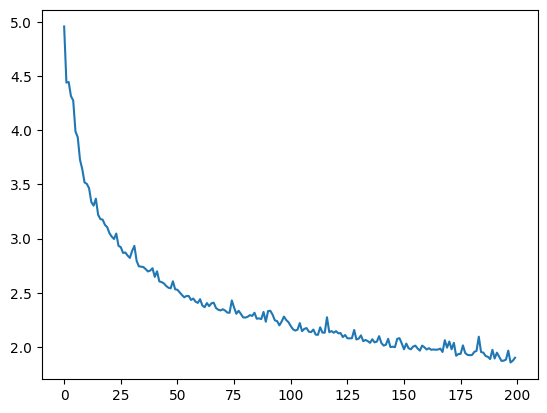

In [142]:
plt.plot([np.log(x) for x in losses])

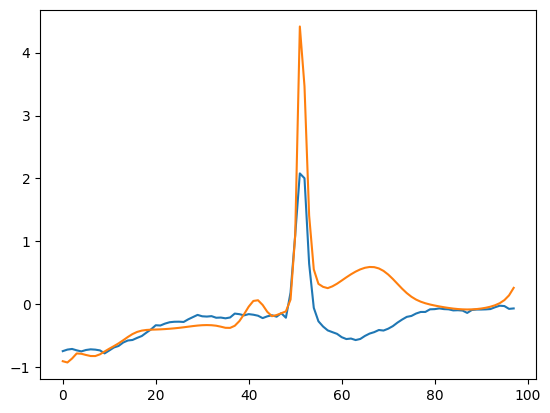

In [139]:
i = 5327

seq, label, _ = beats[i]
seq = torch.tensor(seq, dtype=torch.float32, device=device)
seq = seq.reshape((1,98))
model.eval()
seq_pred = model.forward(seq)

plt.plot(seq.detach().cpu().numpy().reshape(-1))
plt.plot(seq_pred.detach().cpu().numpy().reshape(-1))


# Distribution Difference

In [169]:
users = [{key:[] for key in label_map.keys()} for i in range(48)]

for beat in beats:
    users[beat[2]][beat[1]].append(beat[0])

In [170]:
label_map

{'P': 0, 'R': 1, 'V': 2, 'N': 3, 'L': 4}

In [213]:
[len(x) for x in users[12].values()]

[0, 0, 16, 1910, 0]

In [219]:
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

def encode(beats):
    values = np.stack(beats, axis=1).reshape((-1, 98))
    seq = torch.tensor(values, dtype=torch.float32, device=device)
    model.eval()
    with torch.no_grad():
        encoded = model.encoder.forward(seq)
    encoded = torch.concat(encoded, dim=2).squeeze(0)
    return encoded

def relative_entropy(beats_1, beats_2):
    encode_1 = encode(beats_1).detach().cpu().numpy()
    encode_2 = encode(beats_2).detach().cpu().numpy()

    kde_D1 = KernelDensity(bandwidth=1.0, kernel='gaussian').fit(encode_1)
    kde_D2 = KernelDensity(bandwidth=1.0, kernel='gaussian').fit(encode_2)

    X = np.vstack([encode_1, encode_2])

    log_prob_D1 = kde_D1.score_samples(X)
    log_prob_D2 = kde_D2.score_samples(X)

    prob_D1 = np.exp(log_prob_D1)
    prob_D2 = np.exp(log_prob_D2)

    # Calculate the KL divergence
    kl_divergence = jensenshannon(prob_D1, prob_D2)

    print(kl_divergence)

    return encode_1, encode_2

group_1 = users[9]['N'][:1000]
# group_2 = users[9]['N'][1000:]
group_2 = users[12]['N'][:1000]
# group_2 = users[20]['R'][:1000]

x,y = relative_entropy(group_1, group_2)

0.7498314842870284


(array([ 1.,  1.,  0.,  1.,  0.,  1.,  3.,  1.,  0.,  1.,  1.,  1.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,  2.,
         1.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  2.,
         1.,  0.,  0.,  1.,  0.,  2.,  2.,  0.,  2.,  0.,  1.,  2.,  1.,
         5.,  0.,  1.,  6.,  5.,  3.,  6., 17., 12., 16., 34., 34., 36.,
        54., 66., 63., 75., 59., 68., 58., 73., 36., 29., 31., 24., 17.,
        15., 12., 16., 19., 10.,  8.,  6., 12.,  8.,  3.,  2.,  2.,  1.,
         0.,  2.,  5.,  0.,  1.,  1.,  3.,  2.,  1.]),
 array([-0.97480834, -0.95593017, -0.93705195, -0.91817379, -0.89929557,
        -0.88041741, -0.86153919, -0.84266102, -0.8237828 , -0.80490464,
        -0.78602642, -0.76714826, -0.74827003, -0.72939187, -0.71051365,
        -0.69163549, -0.67275727, -0.65387911, -0.63500094, -0.61612272,
        -0.59724456, -0.57836634, -0.55948818, -0.54060996, -0.52173179,
        -0.50285357, -0.48397541, -0.46509722, -0.44621903, -0.427340

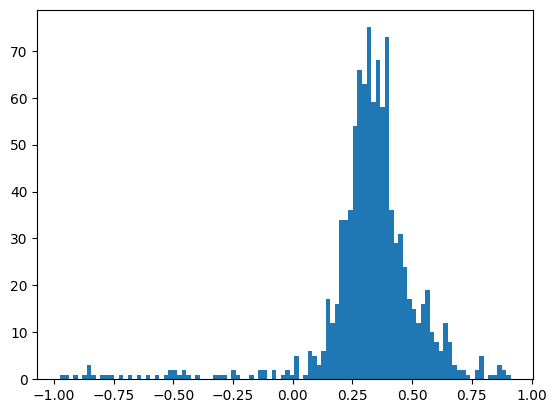

In [225]:
plt.hist(y[:,9], bins=100)